In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import os
from torch.utils.data import Dataset, DataLoader
import sys
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    

seed_everything(42)

In [3]:
# Define the VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))  # Apply ReLU activation
        z_mean = self.fc21(h1)         # Mean of the latent space
        z_log_var = self.fc22(h1)      # Log variance of the latent space
        return z_mean, z_log_var

# Define the VAE Decoder (Generator)
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h3 = torch.relu(self.fc3(z))   # Apply ReLU activation
        return torch.tanh(self.fc4(h3))  # Output layer with tanh activation

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))   # Apply ReLU activation
        return torch.sigmoid(self.fc2(h1))  # Output layer with sigmoid activation
    

In [4]:
# Reparameterization trick for VAE
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [5]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=22050, duration=2):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]  # Only .npy files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        # Load numpy array
        waveform = np.load(file_path)
        # Ensure the audio is 2 seconds long
        target_length = self.sample_rate * self.duration
        if waveform.size < target_length:
            # Pad the waveform if it's shorter than 2 seconds
            waveform = np.pad(waveform, (0, target_length - waveform.size), mode='constant')
        else:
            # Trim the waveform if it's longer than duration
            waveform = waveform[:target_length]
        waveform = waveform.astype(np.float32)
        waveform = (waveform - min(waveform)) / (max(waveform) - min(waveform)) * 2 - 1 
        waveform = waveform/np.max(waveform)
        return torch.tensor(waveform,dtype=torch.float32)  # Convert to tensor

In [6]:
# Path to your .wav files directory
wav_directory = 'C:/Users/Acer/work/git/AudioGAN/audioMNIST/'  # Change this to your directory with .wav files
# Create the dataset and dataloader
batch_size = 128
sample_rate = 48000 
duration = 1 #seconds
dataset = AudioDataset(wav_directory, sample_rate, duration)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataset))

30000


tensor([-0.0995, -0.0995, -0.1014,  ..., -0.0686, -0.0686, -0.0686])
torch.Size([48000])


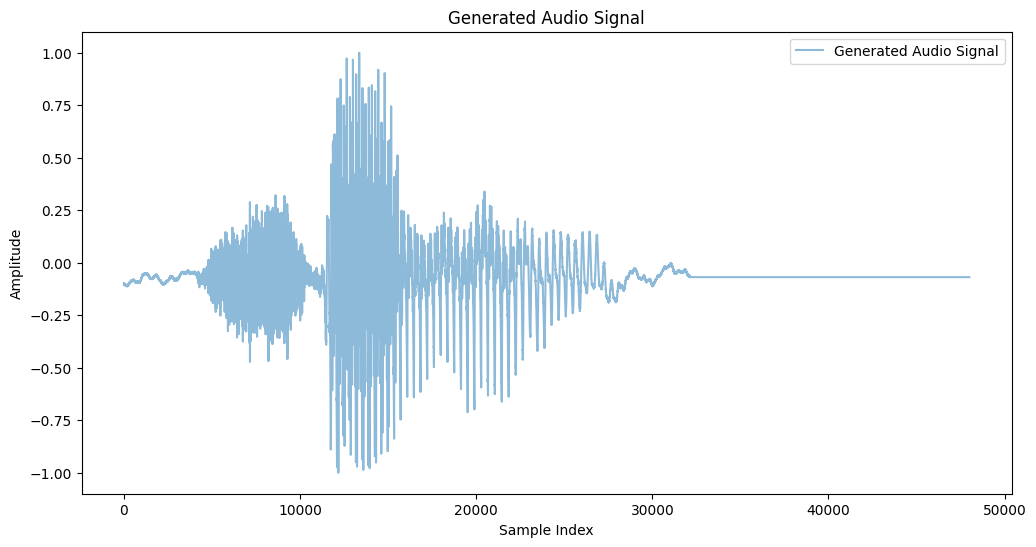

In [7]:
# plot the signal 
for batch in dataloader:
    # Plot the generated audio signal
    plt.figure(figsize=(12, 6))
    print(batch[0])
    print(batch[0].shape)
    plt.plot(batch[0], label='Generated Audio Signal', alpha=0.5)
    plt.title('Generated Audio Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    break

In [8]:
input_dim = sample_rate  # For 1 second of audio at 48 kHz
hidden_dim = 128
latent_dim = 64

vae_encoder = VAEEncoder(input_dim, hidden_dim, latent_dim)
vae_decoder = VAEDecoder(latent_dim, hidden_dim, input_dim)
discriminator = Discriminator(input_dim)

In [ ]:
optimizer_vae = optim.Adam(list(vae_encoder.parameters()) + list(vae_decoder.parameters()), lr=0.00001)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.00002)
kl_losses  = []
vae_gan_losses = []
disc_losses = []
batch_count = 0
for epoch in range(20):
    for real_data in dataloader:
        # real_data is already in the correct shape (batch_size, input_dim)
        # Train Discriminator
        optimizer_disc.zero_grad()
        mu, logvar = vae_encoder(real_data)
        assert not torch.isnan(mu).any()
        assert not torch.isnan(logvar).any()

        z = reparameterize(mu, logvar)
        fake_data = vae_decoder(z)

        disc_real = discriminator(real_data)
        disc_fake = discriminator(fake_data.detach())
        loss_disc = -torch.mean(torch.log(disc_real) + torch.log(1 - disc_fake))
        disc_losses.append(loss_disc.item())
        loss_disc.backward()
        # Gradient clipping for discriminator to avoid nans
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_disc.step()

        # Train VAE-GAN
        optimizer_vae.zero_grad()
        disc_fake = discriminator(fake_data)
        loss_vae_gan = -torch.mean(torch.log(disc_fake))  # Adversarial loss
        vae_gan_losses.append(loss_vae_gan.item())
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
        kl_losses.append(kl_loss.item())
        loss_vae_total = loss_vae_gan + kl_loss
        loss_vae_total.backward()
        # Gradient clipping for encoder and decoder to avoid nans
        torch.nn.utils.clip_grad_norm_(vae_encoder.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(vae_decoder.parameters(), max_norm=1.0)
        optimizer_vae.step()
        if batch_count % 5 == 0:
            print(f'Epoch: {epoch}, VAE Loss: {loss_vae_gan.item()}, Discriminator Loss: {loss_disc.item()}, KL Loss {kl_loss.item()}')
        batch_count +=1

In [ ]:
# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(disc_losses, label='Discriminator Loss')
plt.plot(kl_losses, label='KL Losses')
plt.plot(vae_gan_losses, label='VAE GAN Loss')
plt.title('VAE-GAN Training Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()         

In [ ]:
vae_decoder.eval()
with torch.no_grad():
    z =  torch.randn(1, latent_dim)
    generated_audio = vae_decoder(z).detach().numpy().flatten()
print(generated_audio.shape)
# Plot the generated audio signal
plt.figure(figsize=(12, 6))
plt.plot(generated_audio, label='Generated Audio Signal', alpha=0.5)
plt.title('Generated Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
from scipy.io.wavfile import write
# Assuming the array values are in the range of int16 for WAV format
# Scale the array if necessary
generated_audio = np.int16(generated_audio / np.max(np.abs(generated_audio)) * 32767)
# Save the array as a WAV file
write('generated/generated.wav', sample_rate, generated_audio) 